# Session 2

In this notebook we showcase how to use the "many-particle" models and submodels, i.e. including a distribution of particle sizes. We look at two examples:
1. Many-Particle Model (MPM): a stand-alone "x-averaged" model
2. Many-Particle DFN: particle-size distributions at every electrode "x" location.

## Example: Many-Particle Model (MPM)

The Many Paticle Model (MPM) of a lithium-ion battery is an extension of the Single Particle Model to account for a continuous distribution of active particle sizes in each electrode $\text{k}=\text{n},\text{p}$. Therefore, many of the same model assumptions hold, e.g., the transport in the electrolyte is instantaneous and hence the through-cell variation (in $x$) is neglected. The full set of assumptions and description of the particle size geometry is given in the below reference.

### Reference

Toby L. Kirk, Jack Evans, Colin P. Please, and S. Jonathan Chapman. Modelling electrode heterogeneity in lithium-ion batteries: unimodal and bimodal particle-size distributions. arXiv:2006.12208, 2020. URL: https://arxiv.org/abs/2006.12208, arXiv:2006.12208.


### Particle size geometry

In each electrode $\text{k}=\text{n},\text{p}$, there are spherical particles of each radius $R_\text{k}$ in the range $R_\text{k,min}<R_\text{k}<R_\text{k,max}$, with the fraction of all particles of a given radius $R_\text{k}$ given by the particle-size distribution (base on number)
$f_\text{k,num}(R_\text{k})$. However, it is more convenient to deal with the fraction
of _surface area_ contributed by particles of radius $R_\text{k}$, which we denote $f_{\text{k},a}(R_\text{k})$ and refer to as the _area-weighted_ particle-size distribution. It is sufficient to specify $f_{\text{k},a}(R_\text{k})$, which is present requirement in the MPM.
See Kirk et al. (2020) for more details on the different types of distribution and mean radii. 



### Model equations

In each electrode, only one representative particle of each size $R_\text{k}$ needs to be modelled. The concentration of lithium in the solid particles is denoted $c_{\text{s,k}}(t,R_\text{k}, r_\text{k})$, which varies with time, particle radius $R_\text{k}$, and the radial coordinate $r_{\text{k}} \in[0,R_{\text{k}}]$ within the spherical particle. The potential is uniform across all particles in the electrode, $\phi_{\text{s,k}}(t)$. 

The equations for molar conservation of lithium ($c_{\text{s,k}}$) are then: 
$$
\frac{\partial c_{\text{s,k}}}{\partial t} = -\frac{1}{r_{\text{k}}^2} \frac{\partial}{\partial r_{\text{k}}} \left(r_{\text{k}}^2 N_{\text{s,k}}\right), \\
N_{\text{s,k}} = -D_{\text{s,k}}(c_{\text{s,k}}) \frac{\partial c_{\text{s,k}}}{\partial r_{\text{k}}}, \quad \text{k} \in \text{n, p}, 
$$
$$
N_{\text{s,k}}\big|_{r_{\text{k}}=0} = 0,  \ \  N_{\text{s,k}}\big|_{r_{\text{k}}=R_{\text{k}}} = 
\frac{j_{\text{k}}}{F} \quad \text{k} \in \text{n, p}, \quad\\
c_{\text{s,k}}(0,R_\text{k},r_{\text{k}}) = c_{\text{s,k,0}}, \quad \text{k} \in \text{n, p},$$
where $D_{\text{s,k}}$ is the diffusion coefficient in the solid, $N_{\text{s,k}}$ denotes the flux of lithium ions in the solid particle, $F$ is Faraday's constant. The interfacial current density is given by $j_\text{k}$, which also varies with particle size.

### Algebraic equations for the potentials
The potentials $\phi_{\text{s,k}}(t)$ are determined via the integral constraint that the total current flowing across the electrode interface must equal (up to a minus sign) the through-cell current density $i$. Writing this in terms of the potential differences $\Delta \phi_{\text{s,k}} = \phi_{\text{s,k}} - \phi_{\text{e}}$,
$$
L_\text{k}a_\text{k,tot}\int_{R_\text{k,min}}^{R_\text{k,max}} f_{\text{k},a}(R_\text{k})j_\text{k}\,\text{d}R_\text{k} = \begin{cases}
i,\quad \text{k}=\text{n}\\
-i,\quad \text{k}=\text{p}
\end{cases}
$$
with Butler-Volmer kinetics
$$
j_\text{k}=j_{\text{0,k}} \sinh\left[\frac{F}{2R_g T}(\Delta \phi_{\text{s,k}}-U_{\text{k}}(c_{\text{s},\text{k}}))\right], \ \ j_{\text{0,k}} =  m_{\text{k}}(c_{\text{e}}c_{\text{s,k}})^{1/2}(c_\text{k,max}-c_{\text{s,k}})^{1/2}.
$$
This gives an integral (or algebraic once discretized) equation for $\Delta \phi_{\text{s,k}}$ which is coupled to the concentration equations above.
The terminal voltage is then obtained from
$$
V = \Delta \phi_{\text{s,p}} - \Delta \phi_{\text{s,n}}
$$

## Example solving MPM


In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import matplotlib.pyplot as plt

You should consider upgrading via the '/home/user/PyBaMM/.tox/dev/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Create an instance of the model

In [2]:
model = pybamm.lithium_ion.MPM()

First, let's inspect some variables (e.g. the lithium concentration and interfacial current densities) that depend on particle size $R_\text{k}$. The variables of interest are `X-averaged` versions as there is no dependence on $x$.

In [3]:
model.variables.search("X-averaged negative particle concentration")

X-averaged negative particle concentration
X-averaged negative particle concentration [mol.m-3]
X-averaged negative particle concentration distribution
X-averaged negative particle concentration distribution [mol.m-3]


The concentration that is being solved for in the MPM, and which varies with particle size is the one ending in `"distribution"`. 

In [4]:
c_n_R_dependent = model.variables["X-averaged negative particle concentration distribution"]
c_n_R_dependent.domains

{'primary': ['negative particle'],
 'secondary': ['negative particle size'],
 'tertiary': ['current collector']}

Notice that the secondary domain is `'negative particle size'`, which is treated as another (microscale) domain in PyBaMM.

### Mesh points
 By default, the size domain is discretized into 30 grid points on a uniform 1D mesh - "bins of equal width".

In [5]:
for var, npts in model.default_var_pts.items():
    print(var,'has',npts,'mesh points')

x_n has 20 mesh points
x_s has 20 mesh points
x_p has 20 mesh points
r_n has 30 mesh points
r_p has 30 mesh points
y has 10 mesh points
z has 10 mesh points
R_n has 30 mesh points
R_p has 30 mesh points


## Solve
Now solve the MPM with the default parameters and size distributions (lognormals).

In [6]:
sim = pybamm.Simulation(model)
sim.solve(t_eval=[0, 3600])

# plot some variables that depend on R
output_variables = [
    "X-averaged negative particle surface concentration distribution",
    "X-averaged positive particle surface concentration distribution",
    "Terminal voltage [V]",
    "X-averaged negative area-weighted particle-size distribution",
    "X-averaged positive area-weighted particle-size distribution",
]

sim.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=3580.9687331142245, step=35.80968733114224),…

## Input custom particle-size distributions

In order to solve the MPM, one must input the area-weighted particle-size distribution $f_{\text{k},a}$ for each electrode $\text{k}=\text{n,p}$ and the minimum and maximum radius limits $R_\text{k,min}$, $R_\text{k,max}$. The default distributions $f_{\text{k},a}$, usable with the Marquis et al. [[6]](#References) parameter set, are lognormals with means equal to the `"Negative particle radius [m]"` and `"Positive particle radius [m]"` values, and standard deviations equal to 0.3 times the mean.

You can input any size distribution $f_{\text{k},a}(R_\text{k})$ as a function of $R_\text{k}$, which we will now demonstrate.

Note: $f_{\text{k},a}(R_\text{k})$ should ideally integrate to 1 over the specified $R_\text{k}$ range, although it is automatically normalized within PyBaMM anyway. A distribution such as a lognormal, once restricted to $[R_\text{k,min},R_\text{k,max}]$, discretized, and then renormalized, strictly will not integrate to 1 or have the originally desired mean or variance. The mean and variance of the final discretized distribution can be checked as output variables (see below). Having a sufficient number of mesh points in $R_\text{k}$ or a sufficiently wide interval $[R_\text{k,min},R_\text{k,max}]$ should alleviate this issue, however.

In [7]:
# Parameter set (no distribution parameters by default)
params = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Marquis2019)

# Extract the radii values. We will choose these to be the means of our area-weighted distributions
R_av_n = params["Negative particle radius [m]"]

# Standard deviations (dimensional)
sd_n = 0.2 * R_av_n

# Minimum and maximum particle sizes (dimensional)
R_min_n = 0
R_max_n = 2 * R_av_n


# Set the area-weighted particle-size distributions.
# Choose a lognormal (but any pybamm function could be used)
def f_n(R):
    return pybamm.lognormal(R, R_av_n, sd_n)

# Note: the only argument must be the particle size R


In [8]:
# Positive electrode
R_av_p = params["Positive particle radius [m]"]
sd_p = 0.6 * R_av_p
R_min_p = 0
R_max_p = 3 * R_av_p

def f_p(R):
    return pybamm.lognormal(R, R_av_p, sd_p)


In [9]:
# input distribution params to the dictionary
distribution_params = {
    "Negative minimum particle radius [m]": R_min_n,
    "Positive minimum particle radius [m]": R_min_p,
    "Negative maximum particle radius [m]": R_max_n,
    "Positive maximum particle radius [m]": R_max_p,
    "Negative area-weighted "
    + "particle-size distribution [m-1]": f_n,
    "Positive area-weighted "
    + "particle-size distribution [m-1]": f_p,
}
params.update(distribution_params, check_already_exists=False)


In [10]:
sim = pybamm.Simulation(model, parameter_values=params)
sim.solve(t_eval=[0, 3600])

sim.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=3511.0164027809988, step=35.11016402780999),…

The discretized size distributions can be plotted as histograms. Only the area-weighted distribution has been input, but the corresponding number and volume-weighted ones are also given as output variables.

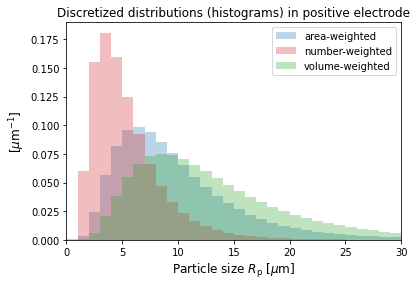

In [11]:

# The discrete sizes or "bins" used, and the distributions
R_p = sim.solution["Positive particle sizes [m]"].entries[:,0] # const in the current collector direction
# The distributions
f_a_p = sim.solution["X-averaged positive area-weighted particle-size distribution [m-1]"].entries[:,0]
f_num_p = sim.solution["X-averaged positive number-based particle-size distribution [m-1]"].entries[:,0]
f_v_p = sim.solution["X-averaged positive volume-weighted particle-size distribution [m-1]"].entries[:,0]


# plot
width_p = (R_p[-1] - R_p[-2])/ 1e-6
plt.bar(R_p / 1e-6, f_a_p * 1e-6, width=width_p, alpha=0.3, color="tab:blue",
           label="area-weighted")
plt.bar(R_p / 1e-6, f_num_p * 1e-6, width=width_p, alpha=0.3, color="tab:red",
           label="number-weighted")
plt.bar(R_p / 1e-6, f_v_p * 1e-6, width=width_p, alpha=0.3, color="tab:green",
           label="volume-weighted")
plt.xlim((0,30))
plt.xlabel("Particle size $R_{\mathrm{p}}$ [$\mu$m]", fontsize=12)
plt.ylabel("[$\mu$m$^{-1}$]", fontsize=12)
plt.legend(fontsize=10)
plt.title("Discretized distributions (histograms) in positive electrode")
plt.show()

# Example: Doyle-Fuller-Newman Model with particle-size distributions

This next example demonstrates the extension of the Doyle-Fuller-Newman (DFN) model to include a distribution of particle sizes at every macroscale location (e.g. through-cell coordinate $x$) within the electrodes. This model, referred to here as the Many-Particle DFN (or MP-DFN), also extends the ideas of the Many-Particle Model or MPM (an $x$-averaged model) into the DFN framework. Note: this differs from a "size distribution in x", where the particle size is a function of $x$ but with only a single size at any given value of $x$.

By default per electrode, the DFN has 1 microscale dimension (the radial coordinate within the active particles, $r_{\mathrm{k}}$, $\mathrm{k}=\mathrm{n,p}$) and 1 macroscale dimension (the through-cell coordinate $x$), and is commonly called "pseudo-2D". The MP-DFN adds another microscale variation with particle size $R_{\mathrm{k}}$, $\mathrm{k}=\mathrm{n,p}$ over an interval $[R_{\mathrm{k,min}}, R_{\mathrm{k,max}}]$, $\mathrm{k}=\mathrm{n,p}$, and thus can be thought of as "pseudo-3D".

## Reference

The model equations for the MP-DFN, which allow for variations in the through-cell $x$ direction and therefore include electrolyte dynamics, are similar to those of the MPM and DFN, and are available in

Toby L. Kirk, Colin P. Please, and S. Jon Chapman. Physical modelling of the slow voltage relaxation phenomenon in lithium-ion batteries. Journal of The Electrochemical Society, 168(6):060554, jun 2021. URL: https://doi.org/10.1149/1945-7111/ac0bf7, doi:10.1149/1945-7111/ac0bf7.

## Example solving the MP-DFN

The MP-DFN can be accessed from the `DFN` model in PyBaMM, and specifying the `"particle size"` option. The default option for `"particle size"` is `"single"`. Let's change this to `"distribution"` and pass to the `DFN` when loading the model.

In [12]:
# choose option(s)
options = {
    "particle size": "distribution"
}

# load model
model = pybamm.lithium_ion.DFN(options=options, name="MP-DFN")

### Solve

Solve for a 1C discharge

In [13]:
# load parameter values into simuluation
solver = pybamm.CasadiSolver(mode="fast")
sim = pybamm.Simulation(model, parameter_values=params, solver=solver) # same params as for MPM

# solve
sim.solve(t_eval=[0, 3500])

In [14]:
# plot some variables that depend on particle size
output_variables = [
    "Negative particle surface concentration distribution",
    "Positive particle surface concentration distribution",
    "X-averaged negative particle surface concentration distribution",
    "X-averaged negative area-weighted particle-size distribution",
    "X-averaged positive area-weighted particle-size distribution",
    "Terminal voltage [V]",
]

# plot
sim.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=3500.0, step=35.0), Output()), _dom_classes=…

The particle size distributions do not vary with $x$, so you can use the "X-averaged" versions to better visualize the discretized distribution in $R$ that PyBaMM uses.

## Compare MP-DFN to MPM and DFN models

The MP-DFN is an extension of the MPM (size distributions, but no x variation) and DFN models (x variation, but no size distribution). Here we compare the three for the same parameter values, for a discharge followed by a relaxation. Note: this is implemented here by specifying the current function to be a Heaviside, not using the `Experiment` class.

In [15]:
models = [
    pybamm.lithium_ion.DFN(options={"particle size": "distribution"}, name="MP-DFN"),
    pybamm.lithium_ion.MPM(),
    pybamm.lithium_ion.DFN()
]

# parameters
params = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Marquis2019)
params = pybamm.get_size_distribution_parameters(params) 

# define current function
t_cutoff = 3450   # [s]
t_rest = 3600  # [s]
I_typ = params["Typical current [A]"]  # current for 1C

def current(t):
    return I_typ * pybamm.EqualHeaviside(t, t_cutoff)

params.update({"Current function [A]": current})
t_eval = [0, t_cutoff + t_rest]

# solve
sims = []
for model in models:
    sim = pybamm.Simulation(model, parameter_values=params, solver=solver)
    sim.solve(t_eval=t_eval)
    sims.append(sim)

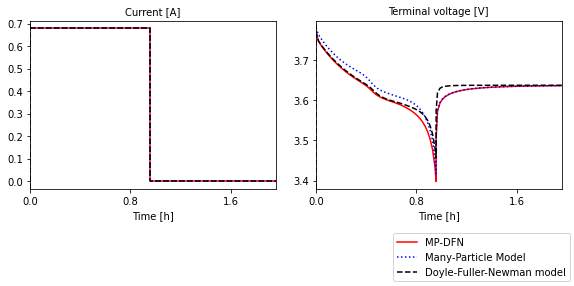

In [16]:
# plot current, terminal voltage 
qp = pybamm.QuickPlot(sims, output_variables=["Current [A]", "Terminal voltage [V]"])
qp.plot(0)

During discharge, the MPM overpredicts the voltage since it neglects the transport (and therefore resistances) through the electrolyte. During the relaxation portion, the DFN overpredicts the rate of relaxation to equilibrium compared to the MP-DFN and MPM. However, the slower relaxation of the size distribution models has been shown to agree better with experiment (Kirk et al. 2021).